In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress
import string

import os
from netCDF4 import Dataset
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D
from scipy.interpolate import griddata

In [5]:
# Import and apply style file for plots
plt.style.use("mpl.style")
%matplotlib inline

### Table of Contents

* [Helper Functions](#helper_functions)
    * [File Handling](#file_handling)
    * [Plotting](#plotting)
* [Global Parameters](#global_parameters)
* [Benchmark 1: Taylor-Green Vortex Flow](#tg_vortex)
* [Benchmark 2: Velocity Divergence Error](#div_u)
* [Benchmark 3: Poiseuille Flow of Newtonian Fluid](#poiseuille_newtonian)
* [Benchmark 4: Poiseuille Flow of a Herschel-Bulkley Fluid](#poiseuille_HB)
* [Benchmark 5: Moving Sphere](#moving_sphere)
* [Benchmark 6: Flow Past a Cylinder](#flow_past_a_cylinder)
* [Benchmark 7: Hydrostatic Tank](#hydrostatic_tank)
* [Benchmark 8: Dam Break ](#dam_break)
* [Benchmark 9: Surface Normal](#surface_normal)
* [Benchmark 10: Thermal Conduction](#thermal_conduction)



# Helper Functions <a class="anchor" id="helper_functions"></a>


## File Handling <a class="anchor" id="file_handling"></a>

In [5]:
#Compile all filenames in a given directory into a dictionary
#value=filepath, key = run properties
def generate_file_names(filepath):
    data_files = {}

    for file in os.listdir(filepath):

        #Remove the .nc extension
        run_code = file.split(".")[0]

        #Add the files to datafiles dictionary
        data_files[run_code]= filepath + "/" + file
    return data_files


def decode_filename(filename, namekey, var0_key, kernel_key):
    """Generate a list of run parameters by "decoding" the filename.
    The input is the filename string, which comes from the key of the
    dictionary returned by generate_filenames. By default, each
    parameter in the filename is decoded by replacing the character p
    (denoting point) with a "." character then converting the whole
    string to a float. Parameters that require special steps for
    decoding are hardcoded below. This function references a namekey
    which defines the file naming convention."""
    # Create a list of coded run parameters
    coded_filename = filename.split("_")
    # Create a list to store decoded run parameters
    decoded_filenamed = []  # to be stored in a df

    for count, param in enumerate(coded_filename):
        # Instructions for decoding the run parameters
        if namekey[count] == "var0":
            decoded_param = var0_key[param]
        elif namekey[count] == "kernel_type":
            decoded_param = kernel_key[param]
        elif namekey[count] == "sf":
            decoded_param = 1 / float(param)
        else:
            decoded_param = param.replace("p", ".")
            decoded_param = float(decoded_param)

        decoded_filenamed.append(decoded_param)
    return decoded_filenamed

#Collect run info from a file name
def parse_file_name(run):
    run_info_coded = run.split("_")
    #Parse the string and perform type conversions and calculations
    run_info_decoded = [] #to be stored in a df
    for count, param in enumerate(run_info_coded):
        if namekey[count] == "var0":
            decoded_param = var0_key[param]
        elif namekey[count] == "kernel_type":
            decoded_param = kernel_key[param]
        elif namekey[count] == "sf":
            decoded_param = 1 / float(param)
        else:
            decoded_param = param.replace("p", ".")
            decoded_param = float(decoded_param)
        run_info_decoded.append(decoded_param)
    return run_info_decoded
    
def gen_col_names(namekey):
    col_names = namekey
    col_names.append("dataset")
    return col_names

def gen_df(infilepath,namekey):
    """Generate a dataframe storing all run information (accessed from filename) and the associated Dataset object."""
    data_files=generate_file_names(infilepath)
    col_names=gen_col_names(namekey)
    df =pd.DataFrame(columns=col_names)
    for run in data_files:
        #Gather run info from the file name
        run_info = parse_file_name(run)
        #Add the dataset object to the run_info
        ds = Dataset(data_files[run])
        run_info.append(ds)
        
        #create a row for the df including run info and the dataset object
        run_df_row = {}
        for count,value in enumerate(run_info):
            run_df_row[col_names[count]]=value
        df = df.append(run_df_row,ignore_index=True)

    return df

## Plotting <a class="anchor" id="plotting"></a>

In [6]:
def order_labels(ax):
    """Reorders the labels for conistency across all figures. The user specifies
    the desired order of labels with the label_order_dict dictionary. The keys
    in this dictionary will be sorted in sequential order based on their value"""
    label_order_dict = {"Quintic":0,"RK0":1,"RK1":2,"RK2":3,"Analytic":4,"other":5}
    handles,labels = ax.get_legend_handles_labels()
    label_order_unsorted = []
    labels_sorted = []
    for label in labels:
        if label in label_order_dict:
            label_order_unsorted.append([label_order_dict[label],label])
        else:
            label_order_unsorted.append([label_order_dict["other"],label])
    label_order_sorted = sorted(label_order_unsorted)
    for label in label_order_sorted:
        labels_sorted.append(label[1])

    handle_dict = dict(zip(labels,handles))
    handles_sorted = []
    for i in labels_sorted:
        handles_sorted.append(handle_dict[i])
    
    return labels_sorted, handles_sorted

def generate_handles(ax):
    """Generates a list of custom handles to be used in a plot legend. Custom handles
    are used when comparing several groups of multiple runs. E.g. comparing shifting
    on and off for all kernel types. In this case, the custom handles would give
    the color and marker style for each of the kernel types. It also gives the 
    linestyle corresponding to shifting on and off.
    """
    #Order the existing labels
    labels_sorted, handles_sorted = order_labels(ax)
    #Return a list of unique labels (removes repeated labels)
    labels_unique = [x for i, x in enumerate(labels_sorted) if labels_sorted.index(x) == i]
    #Add one group of handles associated with color and marker
    marker_handles = []
    for label in labels_unique:
        marker_handles.append(Line2D((0,1), (0,0),
                                color=color_key[label], 
                                marker=marker_key[label],
                                markerfacecolor="None",
                                label=label))
    #Add one group of handles associated with linestyle
    style_handles = []
    for i in var0_key:
        style_handles.append(Line2D((0,1), (0,0),
                                color="black", 
                                linestyle=style_key[var0_key[i]],
                                markerfacecolor="None",
                                label=var0_key[i]))

    return marker_handles, style_handles


def format_plot(ax,y_label,x_label,filename):    
    """Format a plot given the plot ax object, a y axis label, and x axis label, and a filename for the
    saving the plot. Assumes the two plots share the same x axis and have the same legend. If there are
    more than one subplot, annotations of (a), (b), (c) are added at the top left corner of each subplot."""
    legend_size = 20
    if isinstance(ax, np.ndarray):
        for n, i in enumerate(ax):
            i.set_ylabel(y_label)
            i.set_xlabel(x_label)
            marker_handles, style_handles = generate_handles(i)
            i.text(0, 1.025, "("+string.ascii_lowercase[n]+")", transform=i.transAxes, size=20)
        #ax[-1].set_xlabel(x_label) #only put the x label on the bottom panel
        marker_legend = ax[0].legend(handles=marker_handles,loc="lower left", prop={'size': legend_size})
        style_legend = ax[0].legend(handles=style_handles, loc="upper right", prop={'size': legend_size})
        ax[0].add_artist(marker_legend)
        ax[0].add_artist(style_legend)
        plt.tight_layout()
        plt.savefig(filename)
    else:
        ax.set_ylabel(y_label)
        marker_handles, style_handles = generate_handles(ax)
        ax.set_xlabel(x_label)
        marker_legend = ax.legend(handles=marker_handles, prop={'size': legend_size})
        style_legend = ax.legend(handles=style_handles, prop={'size': legend_size})
        ax.add_artist(marker_legend)
        ax.add_artist(style_legend)
        plt.tight_layout()
        plt.savefig(filename)

        

# Global Parameters <a class="anchor" id="global_parameters"></a>

Line color, linestyle, and marker conventions for plotting results

In [1]:
#Naming convention for kernel
kernel_key = {"5":"Quintic","0":"RK0", "1":"RK1", "2":"RK2"}

#Stylistic conventions
color_key = {"Quintic":"#5ec962","RK0":"#21918c", "RK1":"#3b528b","RK2":"#440154","Analytic":"red",'Slope = -1':"red",'Slope = -2':"red",'Slope = -3':"red","Experiment":"red"}
marker_key = {"Quintic":"o","RK0":"X", "RK1":"s","RK2":"d","Analytic":"",'Slope = -1':"None",'Slope = -2':"None",'Slope = -3':"None",'Analytic':"None","Experiment":"x"}
style_key = {"Shifting On":"dotted","Shifting Off":"dashed"}


# Benchmark 1: Taylor-Green Vortex Flow <a class="anchor" id="tg_vortex"></a>

## Helper Functions

In [6]:
def calc_KE_profile(row,dim):
    """Returns the KE vs time for a Taylor Green vortex. Input is a row in the dataframe."""
    ds = row.dataset
    mp = rho0*(row.sf**dim)
    t = ds["time"][:]
    u_x = ds["velocities"][:,:,0] #x component of velocity
    u_y = ds['velocities'][:,:,1] #y component of velocity
    u_z = ds['velocities'][:,:,2] #y component of velocity
    E_x = 0.5*mp*(np.sum(np.abs(u_x), axis=1))**2 #x component of KE
    E_y = 0.5*mp*(np.sum(np.abs(u_y), axis=1))**2 #y component of KE
    E_z = 0.5*mp*(np.sum(np.abs(u_z), axis=1))**2 #z component of KE

    if dim==3:
        E_tot = E_x+E_y+E_z
    elif dim==2:
        E_tot = E_x+E_y

    return t, E_tot

def calc_ref_div_v(ds):
    """Calculate the velocity divergence from an analytical expression. Currently specific to a 2D
    Taylor Green system, which has a velocity divergence of 0."""
    x = ds["coordinates"][frame,:,0]
    #ref_gradv = 2*np.pi/L*u0*np.cos(2*np.pi/L*x) #1D system
    ref_div_v = 0*x
    return ref_div_v

## Global Parameters - 2D

In [7]:
#File naming convention; for extracting simulation parameters from file
namekey = ["var0","kernel_type","sf","hd","eta","u0"]
var0_key = {"1":"Shifting On","0":"Shifting Off"}

#################################
# Simulation parameters
#################################
L = 10 #system size
rho0 = 1 #density
eta = 0.05
nu = eta/rho0 #kinematic viscosity
u_0 = 0.05 #velocity scale

Re = u_0*L/nu #Reynolds number
b_Re = -8*(np.pi)**2/Re #decay factor

dump_interval = 200

## Analysis - 2D

Load the datafile

In [8]:
infilepath = '/ascldap/users/etpaler/test/RHEO_benchmarks/taylor_green_vortex_King_laplacian/2D_vortex/2D_data/ncdf'
df_TG_2D = gen_df(infilepath,namekey)

### Kinetic energy of the Taylor Green Vortex Flow vs time

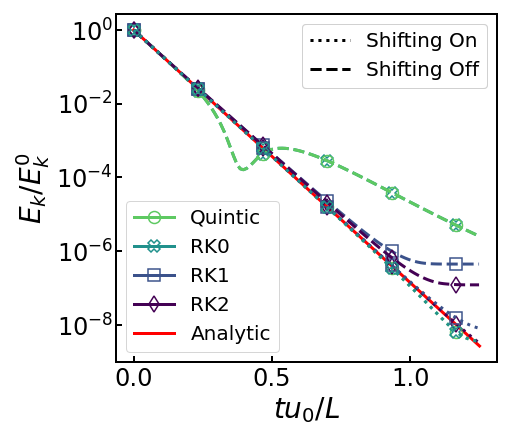

In [9]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
dim = 2

#Subset the main dataframe by parameters of interest
subdf_TG_2D = df_TG_2D[(df_TG_2D.sf==0.1)].copy()

#For each row in the df: plot KE decay profile
for row in subdf_TG_2D.itertuples():

        #Calculate E_tot as a function of time
        t, E_tot = calc_KE_profile(row, dim)

        #plot kinetic energy decay
        ax.semilogy(t*u_0/L,E_tot/E_tot[0],
                        marker=marker_key[row.kernel_type],
                        markevery=20,
                        markerfacecolor="None",
                        color=color_key[row.kernel_type],
                        linestyle=style_key[row.var0],
                        label=row.kernel_type,
                        zorder=2)

#plot analytical kinetic energy decay
t_ref = np.linspace(0,1.25,1000)
KE_0_ref = 0.0625 #obtained analytically in Mathematica
KE_ref = KE_0_ref*np.exp(2*b_Re*t_ref)

ax.plot(t_ref, KE_ref/KE_0_ref,
        label = "Analytic",
        color="red",
        linestyle="solid",
        markerfacecolor="None",
        zorder=0)

y_label = r"$E_k/E^0_k$"
x_label = r"$tu_0/L$"
filepath = "figures/TG2D_profile.svg"
format_plot(ax,y_label,x_label,filepath)

### Viscosity Error
Calculate the fluid viscosity from the rate of kinetic energy decay. Calculate viscosity error by comparing the calculated fluid viscosity to the known fluid viscosity (i.e. the viscosity given as an input when running the simulation).

In [10]:
#Create a copy of main dataframe
nu_error_df = df_TG_2D[(df_TG_2D.var0=="Shifting On")].copy()
#Add a new column to store the L1 norm error of nu
nu_error_df["L1_norm__nu"]=np.nan

#For each row in the df: obtain KE decay profile, calc kinematic viscosity (nu), calc L1 norm for nu
for row in nu_error_df.itertuples():

    #Calculate E_tot as a function of time
    t, E_tot = calc_KE_profile(row,dim)
    
    #Trim the array of dump values to only include stable regime
    dt = 0.1*row.hd*row.sf/3 #c_s=1 for all cases
    tU_L = 1.25 #time below which all runs are stable and not plateaued
    n_steps = tU_L*L/u_0/dt #number of timesteps in the stable time regime
    n_elements = round(n_steps/dump_interval) #number of array elements (representing dumps) in the stable regime
    t_stable = t[:n_elements]
    E_tot_stable = E_tot[:n_elements]

    #calculate nu (kinematic viscosity) from KE decay
    slope = linregress(t_stable*u_0/L, np.log(E_tot_stable/E_tot_stable[0]))[0]
    nu = -slope*L*u_0/16/np.pi**2
    nu_error_df.loc[row.Index,['nu_simulation']] = nu
    #calculate L1 norm for nu and add to df
    nu_0 = row.eta/rho0
    L1_norm = abs(nu-nu_0)/nu_0
    nu_error_df.loc[row.Index,['L1_norm__nu']] = L1_norm

Plot the convergence of the viscosity L1 error with increasing kernel resolution.

Quintic: y=-1.535695149911003x+1.3161820943525326
RK2: y=-1.5412575715734769x+0.3543524184347102
RK1: y=-1.7540726276592091x+1.7195391623462266
RK0: y=-1.535695149911003x+1.3161820943525326


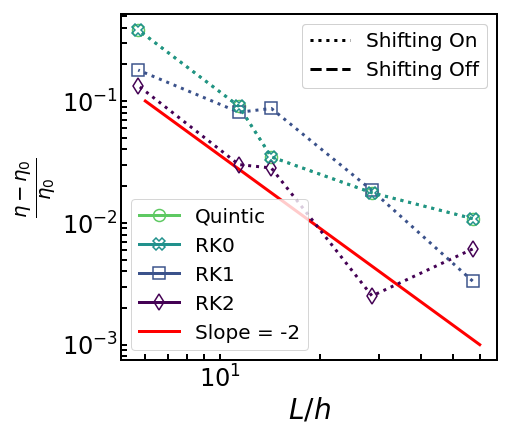

In [11]:
fig, ax = plt.subplots(1,1,figsize=(7,6))

#Plot viscosity convergence as a function of sf for shifting on/off and all kernel types
for i in nu_error_df["var0"].unique():
    subdf_1 = nu_error_df[nu_error_df["var0"]==i]
    for j in subdf_1["kernel_type"].unique():
        subdf_2 = subdf_1[subdf_1["kernel_type"]==j]
        subdf_2 = subdf_2.sort_values(by=["sf"])
        label = j
        ax.loglog(L/(subdf_2["sf"]*subdf_2["hd"]),subdf_2["L1_norm__nu"],
                    color=color_key[j],
                    marker=marker_key[j],
                    linestyle=style_key[i],
                    markerfacecolor="None",
                    label=label,
                    zorder=2)
        #Calculate the best fit line for rate of convergence
        x = np.log(L/(subdf_2["sf"]*subdf_2["hd"]))
        y = np.log(subdf_2["L1_norm__nu"])
        a,b = np.polyfit(x,y,1)
        print("{}: y={}x+{}".format(j,a,b))

    # Add line of slope = 2 for reference
    x_ref = [6,60]
    y_ref = [1e-1,1e-3]
    ax.loglog(x_ref,y_ref, 
                color="red",
                linestyle="solid",
                label="Slope = -2",
                zorder=0)


y_label = r"$\frac{\eta-\eta_0}{\eta_0}$"
x_label = r"$L/h$"
filepath = "figures/TG_convergence.svg"
format_plot(ax,y_label,x_label,filepath)

### Benchmark 2: Velocity Divergence Error <a class="anchor" id="div_u"></a>

In [12]:
#File naming convention; for extracting simulation parameters from file
namekey = ["var0","kernel_type","sf","hd"]
frame = -1

In [13]:
infilepath = "/ascldap/users/etpaler/test/RHEO_benchmarks/gradv/gradv_data/2D/ncdf"
df_TG_2D_divu = gen_df(infilepath,namekey)

In [16]:
df_TG_2D_divu_error = df_TG_2D_divu.copy()
df_TG_2D_divu_error["L1_norm__div_v"]=np.nan


#This can probably be vectorized, but I couldn't figure out how to get it to work
for row in df_TG_2D_divu_error.itertuples():
    ds = row.dataset
    
    x = ds["coordinates"][frame,:,0]
    y = ds["coordinates"][frame,:,1]
    div_v = ds["f_rheo_grad_gradv"][frame,:,0]+ds["f_rheo_grad_gradv"][frame,:,3]

    grid_spaces = L/0.5 #Minimum spacing to ensure all grids have particles
    xi = np.linspace(0,L,int(grid_spaces))
    yi = np.linspace(0,L,int(grid_spaces))
    zi = griddata((x, y), div_v, (xi[None, :], yi[:, None]), method='cubic')

    ref_div_v = 0 #Analytic solution to velocity divergence field for TG flow
    L1_div_v = np.sum(np.abs(zi[1:-1,1:-1]-ref_div_v))*L/u_0/grid_spaces**2
    df_TG_2D_divu_error.loc[row.Index,['L1_norm__div_v']] = L1_div_v

Quintic: y=-0.0269094735493043x+-2.6905903714018606
RK2: y=-2.073153210040081x+-2.2148547409588546
RK1: y=-1.0287625900213988x+-1.8782901991965506
RK0: y=-0.0269094735493043x+-2.6905903714018606


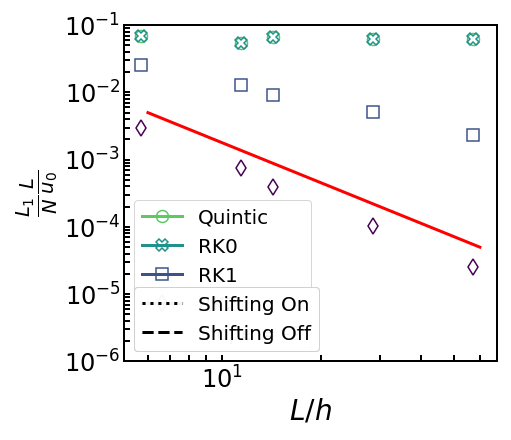

In [20]:
#Create a subset of the viscosity dataframe, only including specified hd

subdf_TG_2D_divu_error = df_TG_2D_divu_error.copy()

fig, ax = plt.subplots(1,1,figsize=(7,6))
#Plot viscosity convergence as a function of sf for shifting on/off and all kernel types
for i in df_TG_2D_divu_error["var0"].unique():
    subdf_1 = df_TG_2D_divu_error[df_TG_2D_divu_error["var0"]==i]
    for j in subdf_1["kernel_type"].unique():
        subdf_2 = subdf_1[subdf_1["kernel_type"]==j]
        subdf_2 = subdf_2.sort_values(by=["sf"])
        label = j
        ax.loglog(L/(subdf_2["sf"]*subdf_2["hd"]),subdf_2["L1_norm__div_v"],
                    color=color_key[j],
                    marker=marker_key[j],
                    linestyle="None",
                    markerfacecolor="None",
                    label=label,
                    zorder=2)
        x = np.log(L/(subdf_2["sf"]*subdf_2["hd"]))
        y = np.log(subdf_2["L1_norm__div_v"])
        a,b = np.polyfit(x,y,1)
        print("{}: y={}x+{}".format(j,a,b))

#Add line of slope = 2 for reference
slope = -2
x_ref = [6,60]
y_ref = [5e-3,5e-5]
ax.loglog(x_ref,y_ref, 
             color="red",
             linestyle="solid",
             label="Slope = -2",
             zorder=0)

y_label = r"$\frac{L_1}{N}\frac{L}{u_0}$"
x_label = r"$L/h$"
filepath = "figures/div_u_convergence.svg"
format_plot(ax,y_label,x_label,filepath)
ax.set_ylim(1e-6,1e-1)
plt.savefig(filepath)

## Analysis - 3D

In [12]:
infilepath = '/ascldap/users/etpaler/test/RHEO_benchmarks/taylor_green_vortex_King_laplacian/3D_vortex/3D_data/ncdf'
df_TG_3D = gen_df(infilepath,namekey)

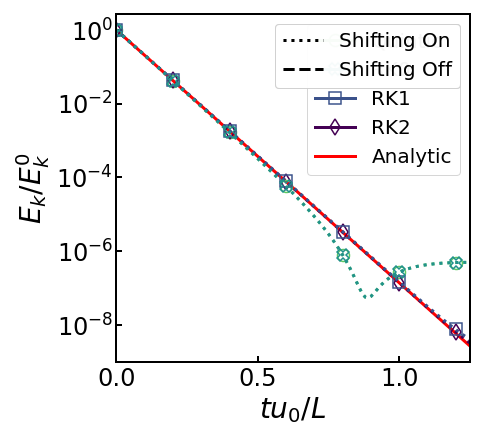

In [13]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
dim = 3

#Subset the main dataframe by parameters of interest
subdf_TG_3D = df_TG_3D[(df_TG_3D.sf==0.1)].copy()

#For each row in the df: plot KE decay profile
for row in subdf_TG_3D.itertuples():

        #Calculate E_tot as a function of time
        t, E_tot = calc_KE_profile(row, dim)

        #plot kinetic energy decay
        ax.semilogy(t*u_0/L,E_tot/E_tot[0],
                        marker=marker_key[row.kernel_type],
                        markevery=20,
                        markerfacecolor="None",
                        color=color_key[row.kernel_type],
                        linestyle=style_key[row.var0],
                        label=row.kernel_type,
                        zorder=2)

#plot analytical kinetic energy decay
t_ref = np.linspace(0,1.25,1000)
KE_0_ref = 0.0625 #obtained analytically in Mathematica
KE_ref = KE_0_ref*np.exp(2*b_Re*t_ref)

ax.plot(t_ref, KE_ref/KE_0_ref,
        label = "Analytic",
        color="red",
        linestyle="solid",
        markerfacecolor="None",
        zorder=0)

ax.set_xlim(0,1.25)
y_label = r"$E_k/E^0_k$"
x_label = r"$tu_0/L$"
filepath = "figures/TG3D_profile.svg"
format_plot(ax,y_label,x_label,filepath)

In [14]:
#Create a copy of main dataframe
nu_df = df_TG_3D.copy()
#Add a new column to store the viscosity calculated from simulation data
nu_df["nu_simulation"]=np.nan
#Add a new column to store the L1 norm error of nu
nu_df["L1_norm__nu"]=np.nan

#For each row in the df: obtain KE decay profile, calc kinematic viscosity (nu), calc L1 norm for nu
for row in nu_df.itertuples():

    #Calculate E_tot as a function of time
    t, E_tot = calc_KE_profile(row,dim)
    
    #Trim the array of dump values to only include stable regime
    dt = 0.1*row.hd*row.sf/3 #c_s=1 for all cases
    tU_L = 1.25 #time below which all runs are stable and not plateaued
    n_steps = tU_L*L/u_0/dt #number of timesteps in the stable time regime
    n_elements = round(n_steps/dump_interval) #number of array elements (representing dumps) in the stable regime
    t_stable = t[:n_elements]
    E_tot_stable = E_tot[:n_elements]

    #calculate nu (kinematic viscosity) from KE decay
    slope = linregress(t_stable*u_0/L, np.log(E_tot_stable/E_tot_stable[0]))[0]
    nu = -slope*L*u_0/16/np.pi**2
    nu_df.loc[row.Index,['nu_simulation']] = nu
    #calculate L1 norm for nu and add to df
    nu_ref = row.eta/rho0
    L1_norm = abs(nu-nu_ref)/nu_ref
    nu_df.loc[row.Index,['L1_norm__nu']] = L1_norm

Quintic: y=-1.2851187600221143x+2.342141844660093
RK2: y=-2.535215025045573x+3.179708231009072
RK0: y=-1.0225266121240026x+1.690514554487913
RK1: y=-1.9118795944717335x+1.7095531183813302


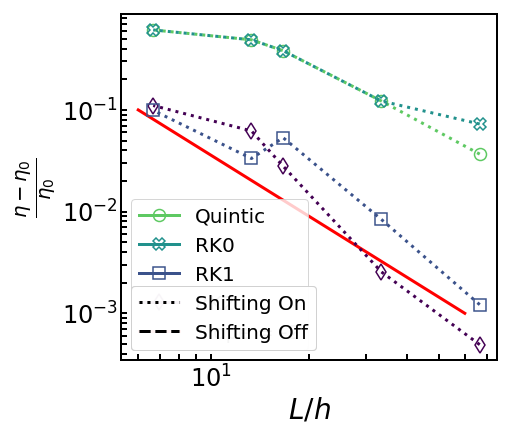

In [16]:
fig, ax = plt.subplots(1,1,figsize=(7,6))

#Create a subset of the viscosity dataframe, only including specified hd
nu_subdf = nu_df.copy()

#Plot viscosity convergence as a function of sf for shifting on/off and all kernel types
for i in nu_subdf["var0"].unique():
    subdf_1 = nu_subdf[nu_subdf["var0"]==i]
    for j in subdf_1["kernel_type"].unique():
        subdf_2 = subdf_1[subdf_1["kernel_type"]==j]
        subdf_2 = subdf_2.sort_values(by=["sf"])
        label = j
        ax.loglog(L/(subdf_2["sf"]*subdf_2["hd"]),subdf_2["L1_norm__nu"],
                    color=color_key[j],
                    marker=marker_key[j],
                    linestyle=style_key[i],
                    markerfacecolor="None",
                    label=label,
                    zorder=2)
        
        #Calculate the best fit line for rate of convergence
        x = np.log(L/(subdf_2["sf"]*subdf_2["hd"]))
        y = np.log(subdf_2["L1_norm__nu"])
        a,b = np.polyfit(x,y,1)
        print("{}: y={}x+{}".format(j,a,b))

    # Add line of slope = 2 for reference
    x_ref = [6,60]
    y_ref = [1e-1,1e-3]
    ax.loglog(x_ref,y_ref, 
                color="red",
                linestyle="solid",
                label="Slope = -2",
                zorder=0)


y_label = r"$\frac{\eta-\eta_0}{\eta_0}$"
x_label = r"$L/h$"
filepath = "figures/TG3D_convergence.svg"
format_plot(ax,y_label,x_label,filepath)

# Benchmark 3: Poiseuille Flow of Newtonian Fluid <a class="anchor" id="poiseuille_newtonian"></a>

## Helper Functions

In [6]:
def poiseuille_analyt_transient(r,t):
    series_exp = 0
    n = np.arange(0,1e6,1)
    for n_i in n:
        series_exp_1 = 16*(-1)**n_i*H**2*-f_ext/nu/np.pi**3/(2*n_i+1)**3 #1st term in the series expansion
        series_exp_2 = np.cos(((2*n_i)+1)*np.pi*r/2/H)  #2nd term in the series expansion
        series_exp_3 = np.exp(-((2*n_i)+1)**2*np.pi**2*nu*t/4/H**2)  #3rd term in the series expansion
        series_exp += (series_exp_1*series_exp_2*series_exp_3)  #full series expansion
    ux_y_t = (-f_ext/2/nu*(r**2-H**2))+series_exp

    return(ux_y_t)

## Benchmark Parameters

In [7]:
#File naming convention; for extracting simulation parameters from file
namekey = ["var0","kernel_type","sf","eta","fext"]
var0_key = {"0":"Newtonian","1":"Power Law"} #Viscosity calc method
style_key = {"Newtonian":"dotted","Power Law":"dashed"}

#################################
# Physical parameters
#################################
#System dimensions
H = 5 #channel "radius"
L_x = 10 #channel length
#Fluid properties
eta = 0.16
rho0 = 1
nu=eta/rho0
#External force
f_ext = 1e-4
#Mean velocity (see Physical hydrodynamics)
U_0 = f_ext*H**2/(6*eta)
#Reynolds number
Re = rho0*H*U_0/eta
#Euler number
Eu = 2*f_ext*H/rho0/U_0**2

print("Reynolds number: " + str(Re))
print("Euler number: " + str(Eu))

################################
# Simulation parameters
#################################
cs = 1
hd = 3
dump_frequency=2000

Reynolds number: 0.08138020833333334
Euler number: 147.45599999999996


## Analysis

In [23]:
infilepath = '/ascldap/users/etpaler/test/RHEO_benchmarks/2D_channel_flow/Newtonian_fluid/channel_data/2D/Newtonian_fluid/ncdf'
df_poiseuille_newtonian = gen_df(infilepath,namekey)

['RK1', 0.1] 0.010416666666666668
['RK1', 0.1] 0.036458333333333336
['RK1', 0.1] 0.7760416666666667
['Quintic', 0.1] 0.010416666666666668
['Quintic', 0.1] 0.036458333333333336
['Quintic', 0.1] 0.7760416666666667
['RK0', 0.1] 0.010416666666666668
['RK0', 0.1] 0.036458333333333336
['RK0', 0.1] 0.7760416666666667


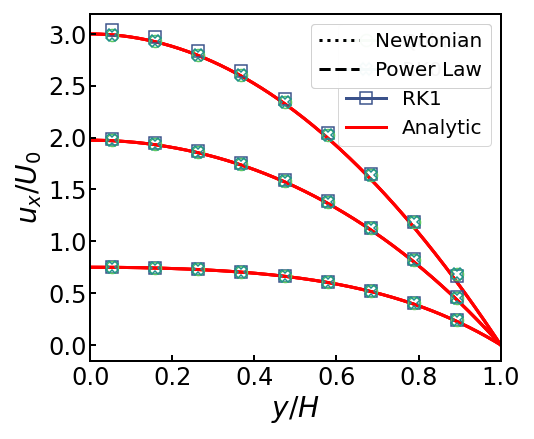

In [26]:
fig, ax = plt.subplots(1,1,figsize=(7,6))

time_samples = np.array([60,150,3000])


subdf_poiseuille_newtonian = df_poiseuille_newtonian[(df_poiseuille_newtonian.sf==0.1)].copy()

for row in u_profile_df_original.itertuples():
    ds = row.dataset
    timestep = 0.1*row.sf*hd/cs/3
    frame_samples = time_samples/dump_frequency/timestep
    frame_samples = frame_samples.astype(int)
    t_sample = ds["time"][frame_samples]


    for count,frame in enumerate(frame_samples):
        fluid_mask = (ds["type"][frame]==1)

        #Extract data
        t = ds["time"][frame]
        x = ds["coordinates"][frame,:,0][fluid_mask]
        y = ds["coordinates"][frame,:,1][fluid_mask]
        u_x = ds["velocities"][frame,:,0][fluid_mask]

        #Plot the analytic solution
        y_analyt = np.linspace(-H,H,1000)
        u_profile_analyt = poiseuille_analyt_transient(y_analyt,t)
        u_x_max = np.max(poiseuille_analyt_transient(y_analyt,t_sample[-1]))
        ax.plot(y_analyt/H,u_profile_analyt/U_0,
                color="red",
                zorder=0,
                label="Analytic")
        tU_L = t*U_0/H
        print([row.kernel_type,row.sf],tU_L)

        #Bin the data into a constant-sized grid
        x_grid_spaces = L_x/0.5 #Minimum spacing to ensure all grids have particles
        y_grid_spaces = 2*H/0.5
        xi = np.linspace(0,L_x,int(x_grid_spaces))
        yi = np.linspace(-H,H,int(y_grid_spaces))
        zi = griddata((x, y), u_x, (xi[None, :], yi[:, None]), method='cubic')

        u_profile = np.mean(zi[1:-1,1:-1],axis=1) #y,x

        #Reformat the data
        data = np.hstack((yi[1:-1,None],u_profile[:,None]))
        data = data[data[:,0].argsort()]

        ax.plot(data[:,0]/H,data[:,1]/U_0,
                linestyle="None",
                zorder=2,
                color=color_key[row.kernel_type],
                lw=3,
                marker=marker_key[row.kernel_type],
                markerfacecolor="None",
                label=row.kernel_type)

ax.set_xlim(0,1)

y_label = r"$u_x / U_0$"
x_label = r"$y / H$"
filepath = "figures/poiseuille_newtonian_profile.svg"
format_plot(ax,y_label,x_label,filepath)

In [31]:
time_samples = np.array([3000])


df_poiseuille_newtonian_error = subdf_poiseuille_newtonian.copy()
df_poiseuille_newtonian_error["L1"]=np.nan

for row in df_poiseuille_newtonian_error.itertuples():
    ds = row.dataset
    timestep = 0.1*row.sf*hd/cs/3
    frame_samples = time_samples/dump_frequency/timestep
    frame_samples = frame_samples.astype(int)
    t_sample = ds["time"][frame_samples]

    for count,frame in enumerate(frame_samples):
        fluid_mask = (ds["type"][frame]==1)

        #Extract data
        t = ds["time"][frame]
        x = ds["coordinates"][frame,:,0][fluid_mask]
        y = ds["coordinates"][frame,:,1][fluid_mask]
        u_x = ds["velocities"][frame,:,0][fluid_mask]

        #Bin the data into a constant-sized grid
        x_grid_spaces = L_x/0.5 #Minimum spacing to ensure all grids have particles
        y_grid_spaces = 2*H/0.5
        xi = np.linspace(0,L_x,int(x_grid_spaces))
        yi = np.linspace(-H,H,int(y_grid_spaces))
        zi = griddata((x, y), u_x, (xi[None, :], yi[:, None]), method='cubic')

        #Simulation velocity profile
        u_profile = np.mean(zi[2:-2,1:-1],axis=1) #y,x
        u_profile_norm = u_profile/np.mean(u_profile)

        #Analytic velocity profile
        u_profile_analyt = poiseuille_analyt_transient(yi[2:-2],t)
        u_profile_analyt_norm = u_profile_analyt/np.mean(u_profile_analyt)

        #L1
        L1 = np.sum(np.abs(u_profile_norm-u_profile_analyt_norm))
        df_poiseuille_newtonian_error.loc[row.Index,['L1']] = L1

NameError: name 'subdf_poiseuille_newtonian' is not defined

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(7,6))

n_nodes = x_grid_spaces * y_grid_spaces

#Plot L1 error as a function of sf for each kernel type
for kernel in df_poiseuille_newtonian_error["kernel_type"].unique():
    subdf = df_poiseuille_newtonian_error[df_poiseuille_newtonian_error["kernel_type"]==kernel]
    ax.loglog(H/(subdf["sf"]*3),subdf["L1"]/(U_0*n_nodes),
            marker=marker_key[kernel],
            markerfacecolor="None",
            color=color_key[kernel],
            linestyle="None",
            label=kernel,
            zorder=2)
    x = np.log(H/(subdf["sf"]*hd))
    y = np.log(subdf["L1"])
    a,b = np.polyfit(x,y,1)
    print("{}: y={}x+{}".format(kernel,a,b))

slope = -1
x_ref = [4,40]
y_ref = [5e-1,5e-2]
ax.loglog(x_ref,y_ref, 
          color="red",
          linestyle="solid",
          label="Slope = -1",
          zorder=0)

y_label = r"$\frac{L_1}{NU_0}$"
x_label = r"$H / h$"
filepath = "figures/poiseuille_newtonian_convergence.svg"
format_plot(ax,y_label,x_label,filepath)

# Benchmark 4: Poiseuille Flow of a Herschel-Bulkley Fluid <a class="anchor" id="poiseuille_HB"></a>

## Helper Functions

In [8]:
def poiseuille_plane_analyt(y,npow,k,dp_dx,H,y0):
    """Calculate the normalized analytical velocity profile for Poiseuille flow through a channel. Input are numpy array of radial positions (r), numpy array of time"""
    prefactor = npow/((npow+1)*k**(1/npow))*dp_dx**(1/npow)
    u_z = np.piecewise(y,[y<y0,y>=y0],[lambda y: prefactor*((H-y0)**((1/npow)+1)),lambda y: prefactor*((H-y0)**((1/npow)+1)-(y-y0)**((1/npow)+1))])        
    return u_z

## Benchmark Parameters

In [9]:
#File naming convention; for extracting simulation parameters from file
namekey = ["var0","kernel_type","sf","eta","fext"]
var0_key = {"0":"Newtonian","1":"Power Law"} #Viscosity calc method
style_key = {"Newtonian":"dotted","Power Law":"dashed"}

#################################
# Simulation parameters
#################################

#Fixed parameters
npow = 0.5
H = 5
f_ext = 0.0002
rho0 = 1
hd = 3.0
d_int = 500

#Herschel-Bulkey Parameters
eta = 0.5
dp_dx = 2e-4
y0 = 0.1
tau0 = y0*dp_dx
gd0 = 5e-4
k = (eta-(tau0/gd0))*gd0**(1-npow)
#The parameters used in the LAMMPS input script are then:
print("Critical strain rate: "+str(gd0))
print("Consistency factor: "+str(k))

y = np.linspace(0,H,10000)
u_x_mean = np.mean(poiseuille_plane_analyt(y,npow,k,f_ext,H,y0))
Bn = tau0*H**npow/k/u_x_mean
print("Bingham #: "+str(Bn))
Re = 1*u_x_mean*H/eta
print("Reynolds #: "+str(Re))
Eu = 2*f_ext*H/rho0/u_x_mean**2
print("Euler number: " + str(Eu))

Critical strain rate: 0.0005
Consistency factor: 0.010285912696499033
Bingham #: 0.3884173074001779
Reynolds #: 0.111936981285879
Euler number: 15.961834895990847


## Analysis

In [10]:
infilepath = '/ascldap/users/etpaler/test/RHEO_benchmarks/2D_channel_flow/HB_fluid/channel_data/2D/HB_fluid/ncdf'
df_poiseuille_HB = gen_df(infilepath,namekey)

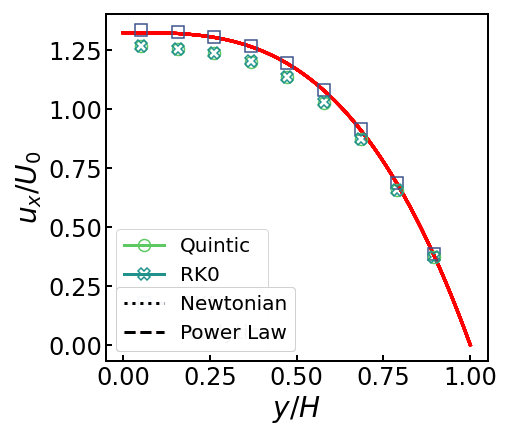

In [11]:
frame = -1

fig, ax = plt.subplots(1,1,figsize=(7,6))

#Create a copy of the main dataframe and subset (if necessary)
df_poiseuille_HB_error = df_poiseuille_HB.copy()
df_poiseuille_HB_error["L1"]=np.nan

#Plot the simulation data
for row in df_poiseuille_HB_error.itertuples():

    ds = row.dataset

    #Plot the analytic solution given the above parameters
    y = np.linspace(0,H,1000)
    u_x_analyt = poiseuille_plane_analyt(y,npow,k,row.fext,H,y0)
    
    ax.plot(y/H,u_x_analyt/u_x_mean,label="Analytic",color="red",zorder=0)

    #Extract data
    fluid_mask = (ds["type"][frame]==1)
    x = ds["coordinates"][frame,:,0][fluid_mask]
    y = ds["coordinates"][frame,:,1][fluid_mask]
    u_x = ds["velocities"][frame,:,0][fluid_mask]

    #Channel length depends on resolution
    if row.sf==0.02:
        L_x = 1
    else:
        L_x = 5

    #Map velocities onto a grid
    grid_spaces = 2*H/0.5 #Minimum spacing to ensure all grids have particles
    xi = np.linspace(0,L_x,int(grid_spaces))
    yi = np.linspace(-H,H,int(grid_spaces))
    zi = griddata((x, y), u_x, (xi[None, :], yi[:, None]), method='cubic')

    #Obtain velocity profile
    r_profile = yi[1:-1] #Each grid space is 0.5, so omit the first three spaces belong to the wall
    u_profile = np.mean(zi[1:-1,1:-1],axis=1) #y,x
    
    #Reformat the profile data for plotting
    u_prof = np.hstack((r_profile[:,None],u_profile[:,None]))
    u_prof = u_prof[u_prof[:,0].argsort()]

    #Exclude R<0 because the data is symmetrical
    u_prof = u_prof[np.logical_not(u_prof[:,0] < 0)]
    u_prof[np.isnan(u_prof)] = 0
    
    #Calculate error with analytic solution
    y_ref = u_prof[:,0]
    u_x_ref = poiseuille_plane_analyt(y_ref,npow,k,row.fext,H,y0)
    
    L1 = np.sum(np.abs(u_prof[:,1]-u_x_ref))
    df_poiseuille_HB_error.loc[row.Index,['L1']] = L1

    if row.sf==0.02:

        #Plot the velocity profile
        ax.plot(u_prof[:,0]/H,u_prof[:,1]/u_x_mean,
                        marker=marker_key[row.kernel_type],
                        markerfacecolor="None",
                        color=color_key[row.kernel_type],
                        linestyle="None",
                        label=row.kernel_type,
                        zorder=2)

y_label = r"$u_x / U_0$"
x_label = r"$y / H$"
filepath = "figures/poiseuille_power_law_profile.svg"
format_plot(ax,y_label,x_label,filepath)

RK1: y=-1.2261224920816376x+-2.211423821419942
Quintic: y=-0.6937568902217413x+-3.0028850520634394
RK0: y=-0.6953048341464012x+-2.999768032425441


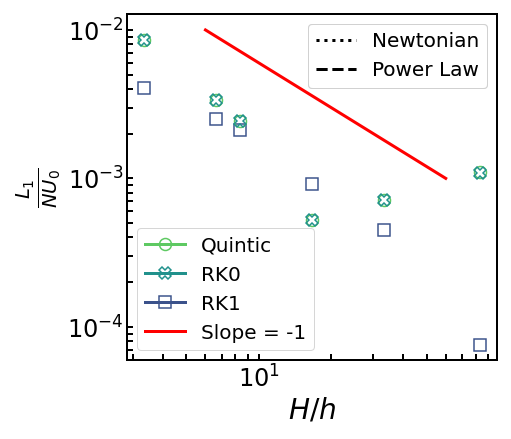

In [12]:
fig, ax = plt.subplots(1,1,figsize=(7,6))

for kernel in df_poiseuille_HB_error["kernel_type"].unique():
    subdf = df_poiseuille_HB_error[df_poiseuille_HB_error["kernel_type"]==kernel]
    ax.loglog(H/(subdf["sf"]*3),subdf["L1"]/(u_x_mean*grid_spaces**2),
            marker=marker_key[kernel],
            markerfacecolor="None",
            color=color_key[kernel],
            linestyle="None",
            label=kernel)
    x = np.log(H/(subdf["sf"]*hd))
    y = np.log(subdf["L1"])
    a,b = np.polyfit(x,y,1)
    print("{}: y={}x+{}".format(kernel,a,b))


slope = -1
x_ref = [6,60]
y_ref = [1e-2,1e-3]
ax.loglog(x_ref,y_ref, 
          color="red",
          linestyle="solid",
          label="Slope = -1",
          zorder=0)

y_label = r"$\frac{L_1}{NU_0}$"
x_label = r"$H / h$"
filepath = "figures/poiseuille_power_law_convergence.svg"
format_plot(ax,y_label,x_label,filepath)

# Benchmark 5: Moving Sphere <a class="anchor" id="moving_sphere"></a>

## Analysis

In [22]:
data = pd.read_csv('PlotData_Normalized_KiTae.csv')

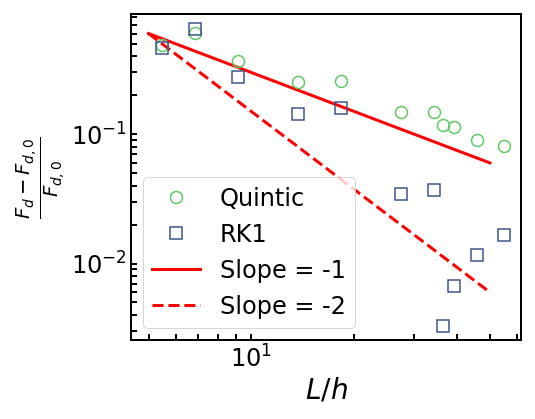

In [23]:
fig, ax = plt.subplots(1,1,figsize=(7,6))

ax.loglog(data["L/h"],data["Fd_norm_Quintic"],
                linestyle="None",
                zorder=2,
                color=color_key["Quintic"],
                lw=3,
                marker=marker_key["Quintic"],
                markerfacecolor="None",
                label="Quintic")

ax.loglog(data["L/h"],data["Fd_norm_CRK1"],
                linestyle="None",
                zorder=2,
                color=color_key["RK1"],
                lw=3,
                marker=marker_key["RK1"],
                markerfacecolor="None",
                label="RK1")

x_ref = [5,50]
y_ref = [0.6,0.06]
ax.loglog(x_ref,y_ref,
            zorder=0, 
            color="red",
            label="Slope = " + str(-1))

x_ref = [5,50]
y_ref = [0.6,0.006]
ax.loglog(x_ref,y_ref,
          zorder=0,
          linestyle="dashed",
          color="red",
          label="Slope = " + str(-2))


ax.legend()
ax.set_ylabel(r"$\frac{F_d-F_{d,0}}{F_{d,0}}$")
ax.set_xlabel(r"$L/h$")
filepath = "figures/stokes_drag.svg"
plt.savefig(filepath,)

# Benchmark 6: Flow Past a Cylinder <a class="anchor" id="flow_past_a_cylinder"></a>

## Helper Functions

## Benchmark Parameters

In [26]:
D = 8
xhi = 144 #from initial data file
L_y = 6*D #from original data file
stripwidth = xhi/96
center_x = 72 #x coordinate of cylinder center
center_x += stripwidth #account for inlet changing box dimensions
u0 = stripwidth/60
eta = 2
rho = 1
Re = rho*u0*D/eta
print("Re={}".format(Re))

namekey = ["var0","kernel_type","sf","Re","dt","dint"]
var0_key = {"0":"quintic","1":"default"}
marker_key_sf = {0.50:"s",0.25:"o"}


infilepath = "/ascldap/users/etpaler/test/RHEO_benchmarks/flow_around_cylinder/cylinderflow_reduced_Re/flow_around_cylinder_data/outlet_treatment/reduced_Re/ncdf"

runs = []
frames = []
for folder in os.listdir(infilepath):
    runs.append(folder)
    run_frames = []
    for frame in os.listdir(infilepath+"/"+folder):
        run_frames.append(frame)
        run_frames.sort()
    frames.append(run_frames)


Re=0.1


## Analysis

In [27]:
col_names = namekey
col_names.append("ncdf_filepath")
df =pd.DataFrame(columns=col_names)

for run in runs:
    run_code = run.split(".")[1]
    #Gather run info from the file name
    run_info = parse_file_name(run_code)   
    #create a row for the df including run info and the dataset object
    run_df_row = {}
    for count,value in enumerate(run_info):
        run_df_row[namekey[count]]=value
    run_df_row["ncdf_filepath"] = run
    df = df.append(run_df_row,ignore_index=True)

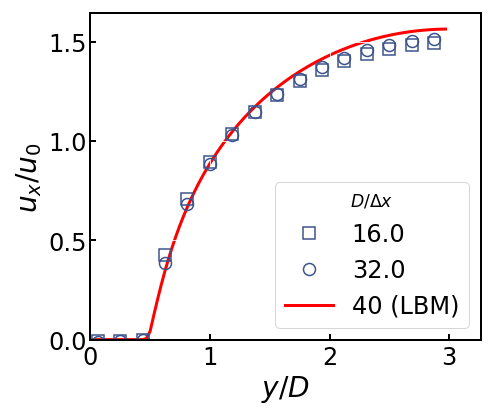

In [28]:
fig, ax = plt.subplots(1,1,figsize=(7,6))


xi = np.arange(0,xhi+stripwidth,0.5)
yi = np.arange(-(L_y/2),(L_y/2),0.5)
x_grid_spaces = len(xi) #Minimum spacing to ensure all grids have particles
y_grid_spaces = len(yi)

for row in df[df.var0=="default"].itertuples():
    run_filepath = infilepath+"/"+row.ncdf_filepath
    u_x_t = np.zeros([len(os.listdir(run_filepath)),y_grid_spaces-1])
    for count,file in enumerate(os.listdir(run_filepath)):
    #Get the time from the filename extension
        frame = int(file.split(".")[1])
        time = frame*row.dint*row.dt
        ds = Dataset(run_filepath+"/"+file)
        x = ds["coordinates"][0,:,0]
        y = ds["coordinates"][0,:,1]#[mask]
        u_x = ds["velocities"][0,:,0]#[mask]

        zi = griddata((x, y), u_x, (xi[None, :], yi[:, None]), method='cubic')

        u_x_i = zi[1:,int(xhi+stripwidth/0.5)] #y,x
        u_x_t[count]=u_x_i
    u_x_t_avg = np.mean(u_x_t,axis=0)

    #Reformat the data
    data = np.hstack((yi[1:,None],u_x_t_avg[:,None]))
    data = data[data[:,0].argsort()]

    ax.plot(data[:,0]/D,data[:,1]/u0,
            label=D/row.sf,
            color=color_key[row.kernel_type],
            marker=marker_key_sf[row.sf],
            markerfacecolor="none",
            markevery=3,
            linestyle="none",
            zorder=2)
    ax.legend(bbox_to_anchor=(1,1), loc="upper left")


LBM_data = np.loadtxt("cylinder_flow_LBM_data_Re0p1.csv", delimiter=",")
ax.plot(LBM_data[:,0],LBM_data[:,1],
        label="40 (LBM)",
        color="red",
        zorder=0)

ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
y_label = r"$u_x/u_0$"
x_label = r"$y/D$"
filename = "flow_around_cylinder_kunz"

# legend_size = 20
# style_legend = ax.legend(handles=order_labels(ax)[1], prop={'size': legend_size})
ax.legend(title = r"$D/\Delta x$",title_fontsize="xx-large")
# ax.add_artist(style_legend)
ax.set_ylabel(y_label)
ax.set_xlabel(x_label)
plt.grid()
plt.savefig("figures/"+filename+".svg")



# Benchmark 7: Hydrostatic Tank <a class="anchor" id="hydrostatic_tank"></a>

## Helper Functions

In [13]:
def calc_center_P(ds,sf):
    """Calculate the pressure along the vertical center line in a hydrostatic tank. Input is LAMMPS simulation data (dataset format) and the scaling factor (sf) of the simulation."""
    fluid_mask = (ds['type'][frame]==1)
    x = ds["coordinates"][frame,:,0][fluid_mask]
    y = ds["coordinates"][frame,:,1][fluid_mask]    
    rho = ds["c_den"][frame][fluid_mask]
    x_grid_spaces = L_x/0.5 #Minimum spacing to ensure all grids have particles
    y_grid_spaces = L_y/0.5
    xi = np.linspace(x_bounds[0],x_bounds[1],int(x_grid_spaces))
    yi = np.linspace(0,H,int(y_grid_spaces))
    zi = griddata((x, y), rho, (xi[None, :], yi[:, None]), method='cubic')
    rho_center = zi[1:-1,int(L_x/2)]

    h = H - yi[1:-1]
    #calculate pressure from equation of state
    p_center = c_s**2*(rho_center-rho0)

    return h, p_center, rho_center

## Benchmark Parameters

In [14]:
#File naming convention; for extracting simulation parameters from file
namekey = ["var0","kernel_type","sf","fext","H","surf_cutoff"]

#################################
# Simulation parameters
#################################

H = 10 #height of column
x_bounds = [0,20] #for the fluid NOT the box
y_bounds = [0,20]
L_x = x_bounds[1]-x_bounds[0]
L_y = y_bounds[1]-y_bounds[0]
rho0 = 1
fext=0.001
c_s = 1 #speed of sound

#Frame
frame = -1

## Analysis

In [8]:
infilepath = "/ascldap/users/etpaler/test/RHEO_benchmarks/hydrostatic/hydrostatic_data/ncdf"
df_hydrostatic = gen_df(infilepath,namekey)

IndexError: list index out of range

NameError: name 'df_hydrostatic' is not defined

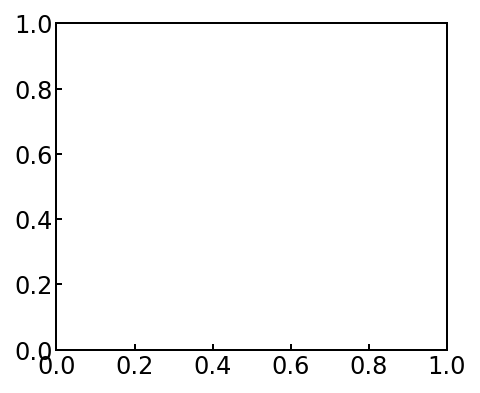

In [9]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
subdf_hydrostatic = df_hydrostatic[(df_hydrostatic.sf==0.1)].copy()

for row in subdf_hydrostatic.itertuples():
    ds = row.dataset
    h,p,rho = calc_center_P(ds,row.sf)
    #plot pressure vs height
    ax.plot(h/H,p/(rho*row.fext*H),
                marker=marker_key[row.kernel_type],
                markevery=2,
                markerfacecolor="None",
                color=color_key[row.kernel_type],
                linestyle="None",
                label=row.kernel_type,
                zorder=2)

#plot analytical pressure profile
h = np.linspace(0,H,50)
p_static = rho0*fext*H
p_ref = np.linspace(0,p_static,len(h))

ax.plot(h/H, p_ref/p_static,
        label = "Analytic",
        color="red",
        linestyle="solid",
        markerfacecolor="None",zorder=0)

x_label = r"$h/H$"
y_label = r"$p/ \rho g H$"
filepath = "figures/hydrostatic_profile.svg"
format_plot(ax,y_label,x_label,filepath)


# Benchmark 8: Dam Break <a class="anchor" id="dam_break"></a>

## Helper Functions

## Benchmark Parameters 

In [13]:
#File naming convention; for extracting simulation parameters from file
namekey = ["var0","kernel_type","sf"]
var0_key = {"1":"Power Law","0":"Newtonian"}
style_key = {"Newtonian":"dotted","Power Law":"dashed"}

#################################
# Simulation parameters
#################################
H=20
L=10
hd=3.5
fext=0.0245
eta=0.05

## Analysis

In [14]:
infilepath = "/ascldap/users/etpaler/test/RHEO_benchmarks/dam_break/dam_break_data/ncdf_renamed"
df_dambreak = gen_df(infilepath,namekey)

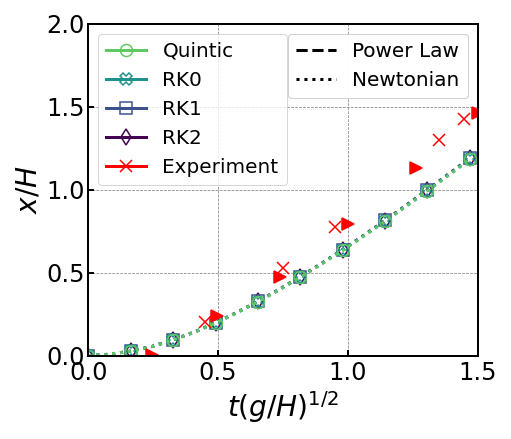

In [15]:
fig, ax = plt.subplots(1,1,figsize=(7,6))

for row in df_dambreak.itertuples():
    ds = row.dataset
    t = ds["time"][:19] #Selected time at index 19 to match the available experimental data
    mask = ds["type"][:19]==2 #masked array suppresses true, so we choose solid particles
    x = ds["coordinates"][:19,:,0]
    x_fluid  = np.ma.masked_array(x, mask)
    
    leading_x = np.max(x_fluid,axis=1)-L #set the "dam" position to be 0
    
    ax.plot(t*np.sqrt(fext/H),leading_x/H,
                marker=marker_key[row.kernel_type],
                markerfacecolor="None",
                markevery=2,
                color=color_key[row.kernel_type],
                linestyle=style_key[row.var0],
                label=row.kernel_type)

#Experimental data (Martin and Moyce 1952)
x = [0.44964370546318283,0.7505385847649562,0.949466939181351,1.349643705463183,1.4491078826713806]
y = [0.2023255813953484,0.5255813953488369,0.7767441860465114,1.3023255813953485,1.4279069767441857]
ax.plot(x, y,
        label = "Experiment",
        marker="x",
        color="red",
        linestyle="None")


#ICSPH Data (Shao & Lo 2002)
x = [0.2457,0.49706,0.738791,0.999,1.2622,1.5013]
y = [0.0062791,0.23953,0.47209,0.7907,1.1302,1.4628]
ax.plot(x, y,
        label = "Experiment",
        marker=">",
        color="red",
        linestyle="None")

x_label = r"$t(g/H)^{1/2}$"
y_label = r"$x/H$"
ax.set_xlim(0,1.5)
ax.set_ylim(0,2)
ax.grid(color = 'grey', linestyle = '--', linewidth = 0.75, axis='both')
filepath = "figures/dam_break_leading_edge.svg"
format_plot(ax,y_label,x_label,filepath)



# Benchmark 9: Surface Normal <a class="anchor" id="surface_normal"></a>

## Helper Functions

In [17]:
#Calculate the analytically determined surface normal as a function of x and y
def calc_ref_normal(x,y,geometry):
    if geometry == "Circular":
        n_x = x/np.sqrt(x**2+y**2)
        n_y = y/np.sqrt(x**2+y**2)
    if geometry == "Sinusoidal":
        omega = 2*np.pi/L
        n_mag = np.sqrt((omega*np.cos(omega*x))**2+1)
        n_x = -omega*np.cos(omega*x)/n_mag
        n_y = 1/n_mag
    
    return n_x, n_y

## Benchmark Parameters

In [18]:
#File naming convention; for extracting simulation parameters from file
namekey = ["var0","kernel_type","sf"]
var0_key = {"1":"Sinusoidal","0":"Circular"}
style_key = {"Sinusoidal":"dotted","Circular":"dashed"}

#################################
# Simulation parameters
#################################
#Frame
frame = -1
hd = 3.5

#Radius of the circle
R_circle = 2.5
#Minimum radius of curvature for the sin curve
L = 10
x = np.linspace(L/2+1e-6,L,1000)
R_sin = (1+(2*np.pi/10)**2*(np.cos(2*np.pi*x/10))**2)**(3/2)/(-(2*np.pi/10)**2*np.sin(2*np.pi*x/10))
R_sin_min = np.min(R_sin)

R = [R_circle,R_sin_min]

## Analysis

In [19]:
infilepath = "/ascldap/users/etpaler/test/RHEO_benchmarks/surf_normal/ncdf"
df_surface_norm = gen_df(infilepath,namekey)


In [20]:
df_surface_norm_error = df_surface_norm[(df_surface_norm.kernel_type=="Quintic")].copy()
df_surface_norm_error["L1_norm__surf_norm"]=np.nan


#This can probably be vectorized, but I couldn't figure out how to get it to work
for row in df_surface_norm_error.itertuples():
    ds = row.dataset
    geometry = row.var0
    #Mask to only include surface atoms
    surface_mask = (ds["c_surf"][frame][:] == 2) #c_surf=2 for surface
    #Position and surface normal from data
    x = ds["coordinates"][frame,:,0][surface_mask]
    y = ds["coordinates"][frame,:,1][surface_mask]
    n_x = ds["f_2"][frame,:,0][surface_mask]
    n_y = ds["f_2"][frame,:,1][surface_mask]
    #Calculate magnitude of error vector
    n_error_mag = []
    for i in range(len(x)):
        #if statement to only consider the top surface of the sinusoidal object
        if geometry == "Sinusoidal":
            if (0<x[i]<L) & (y[i]>=(L-2)):
                n_x_ref,n_y_ref = calc_ref_normal(x[i],y[i],geometry)
                n_x_err = n_x_ref-n_x[i]
                n_y_err = n_y_ref-n_y[i]
                n_err = np.array([n_x_err,n_y_err])
                n_err_mag_i = np.sqrt(n_err.dot(n_err))
                n_error_mag.append(n_err_mag_i)
        #no restrictions for circular geometry
        elif geometry == "Circular":
            n_x_ref,n_y_ref = calc_ref_normal(x[i],y[i],geometry)
            n_x_err = n_x_ref-n_x[i]
            n_y_err = n_y_ref-n_y[i]
            n_err = np.array([n_x_err,n_y_err])
            n_err_mag_i = np.sqrt(n_err.dot(n_err))
            n_error_mag.append(n_err_mag_i)
    L1_norm_surf_norm = np.sum(n_error_mag)/np.shape(n_error_mag)[0] #
    df_surface_norm_error.at[row.Index,"L1_norm__surf_norm"] = L1_norm_surf_norm

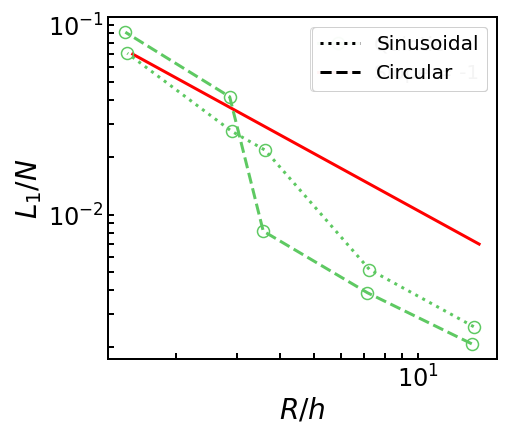

In [22]:
#Create a subset of the viscosity dataframe, only including specified hd

fig, ax = plt.subplots(1,1,figsize=(7,6))
#Plot viscosity convergence as a function of sf for shifting on/off and all kernel types
for count, i in enumerate(df_surface_norm_error["var0"].unique()):
    subdf_1 = df_surface_norm_error[df_surface_norm_error["var0"]==i]
    for j in subdf_1["kernel_type"].unique():
        subdf_2 = subdf_1[subdf_1["kernel_type"]==j]
        subdf_2 = subdf_2.sort_values(by=["sf"])
        label = j
        ax.loglog(R[count]/(subdf_2["sf"]*hd),subdf_2["L1_norm__surf_norm"],
                    color=color_key[j],
                    marker=marker_key[j],
                    linestyle=style_key[i],
                    markerfacecolor="None",
                    label=label)

# Add line of slope = 1 for reference
x_ref = [1.5,15]
y_ref = [0.7e-1,0.7e-2]
ax.loglog(x_ref,y_ref, 
             color="red",
             linestyle="solid",
             label="Slope = -1",zorder=0)

y_label = r"$L_1/N$"
x_label = r"$R/h$"
filepath = "figures/surf_normal_convergence.svg"
format_plot(ax,y_label,x_label,filepath)

# Benchmark 10: Thermal Conduction <a class="anchor" id="thermal_conduction"></a>

## Helper Functions

In [23]:
def calc_T_analyt(t,L,x):
    
    #For a sinusoidal temperature profile
    T = (np.sin(np.pi*x/L)*np.exp(-(np.pi/L)**2*alpha_in*t))
                       
    return T

## Benchmark Parameters

In [24]:
#File naming convention; for extracting simulation parameters from file
namekey = ["var0","kernel_type","sf"]
kernel_key = {"5":"Quintic","0":"RK0", "1":"RK1", "2":"RK2"}
var0_key = {"1":"Shifting On","0":"Shifting Off"}
style_key = {"Shifting On":"dotted","Shifting Off":"dashed"}

#Fluid parameters
rho0 = 1
D = 0.1
cv = 1
alpha_in = D*rho0/cv #thermal diffusivity, kappa in lammps script
print(alpha_in)

#Geometric parameters
L_x = 10 #of the fluid NOT the box
L_y = L_x

#Simulation parameters
cs = 1
hd=3.5
dump_frequency = 500

0.1


## Analysis

In [25]:
infilepath = "/ascldap/users/etpaler/test/RHEO_benchmarks/thermal/conduction/conduction_data/ncdf"
df_conduction = gen_df(infilepath,namekey)

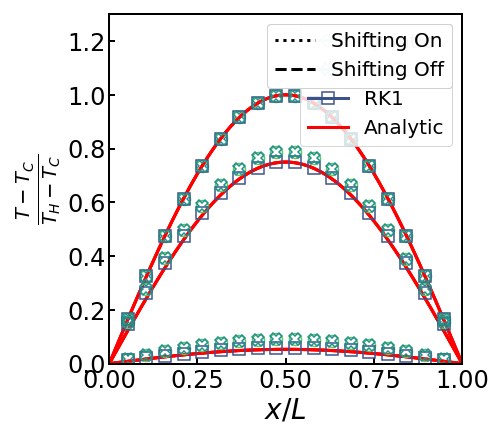

In [26]:
fig, ax = plt.subplots(1,1,figsize=(7,6))

time_samples = np.array([3,30,300])

subdf_conduction = df_conduction[(df_conduction.sf==0.1)]

for row in subdf_conduction.itertuples():
    ds = row.dataset
    timestep = 0.1*hd*row.sf/cs/3
    frame_samples = time_samples/dump_frequency/timestep
    frame_samples = frame_samples.astype(int)
    t_sample = ds["time"][frame_samples]

    for count,frame in enumerate(frame_samples):
        fluid_mask = (ds["type"][frame]==1)

        #Extract data
        x = ds["coordinates"][frame,:,0][fluid_mask]
        y = ds["coordinates"][frame,:,1][fluid_mask]
        T = ds["c_temp"][frame][fluid_mask]

        #Bin the data into a constant-sized grid
        x_grid_spaces = L_x/0.5 #Minimum spacing to ensure all grids have particles
        y_grid_spaces = L_y/0.5
        xi = np.linspace(0,L_x,int(x_grid_spaces))
        yi = np.linspace(0,L_y,int(y_grid_spaces))
        zi = griddata((x, y), T, (xi[None, :], yi[:, None]), method='cubic')

        #Calculate T along the y - centerline (the x-axis)
        T_center = zi[int(L_x/2),1:-1] #y,x

        #Reformat the data
        data = np.hstack((xi[1:-1,None],T_center[:,None]))
        data = data[data[:,0].argsort()]
        ax.plot(data[:,0]/L_x,data[:,1],linestyle="None",zorder=2,color=color_key[row.kernel_type],lw=3,
                marker=marker_key[row.kernel_type],
                markerfacecolor="None",
                label=row.kernel_type)

        x_ref=np.linspace(0,L_x,1000)
        T_ref = calc_T_analyt(t_sample[count],L_x,np.linspace(0,L_x,1000))
        ax.plot(x_ref/L_x,T_ref,zorder=1,color="red",lw=3,label="Analytic")
        ax.set_xlim(0,1)

x_label = r"$x/L$"
y_label = r"$\frac{T-T_C}{T_H-T_C}$"
ax.set_ylim(0,1.3)
filepath = "figures/conduction_profile.svg"
format_plot(ax,y_label,x_label,filepath)




In [27]:
#Create a copy of main dataframe
df_conduction_error = df_conduction#[main_df.kernel_type=="RK1"]
#Add a new column to store the viscosity calculated from simulation data
df_conduction_error["alpha_simulation"]=np.nan
#Add a new column to store the L1 norm error of alpha
df_conduction_error["error__alpha"]=np.nan

#For each row in the df: obtain T decay profile, calc thermal diffusivity (alpha), calc L1 norm for alpha
for row in df_conduction_error.itertuples():
    ds = row.dataset

    #Calculate T(x=5) as a function of time
    t = ds["time"][:]
    mean_T_center = np.zeros(t.shape)
    for i,t_i in enumerate(t): #griddata doesn't work on multidimensional array
        #Extract data
        fluid_mask = (ds["type"][i]==1)
        x = ds["coordinates"][i,:,0][fluid_mask]
        y = ds["coordinates"][i,:,1][fluid_mask]
        T = ds["c_temp"][i,:][fluid_mask]

        #Bin the data into a constant-sized grid
        x_grid_spaces = L_x/0.5 #Minimum spacing to ensure all grids have particles
        y_grid_spaces = L_y/0.5
        xi = np.linspace(0,L_x,int(x_grid_spaces))
        yi = np.linspace(0,L_y,int(y_grid_spaces))
        zi = griddata((x, y), T, (xi[None, :], yi[:, None]), method='cubic')
        
        #Calculate T along the y - centerline (the x-axis)
        T_center = zi[1:-1,int(L_x/2)]
        # print(t_i,row.kernel_type,row.sf)
        # print(T_center)
        mean_T_center[i] = np.mean(T_center) #y,x
        # print(mean_T_center)

    #calculate alpha from T vs t slope
    slope = linregress(t, np.log(mean_T_center))[0]
    alpha = -slope*(L_x/np.pi)**2
    df_conduction_error.loc[row.Index,['alpha_simulation']] = alpha

    #calculate L1 norm for alpha and add to df
    error_alpha = abs(alpha-alpha_in)/alpha_in
    df_conduction_error.loc[row.Index,['error__alpha']] = error_alpha

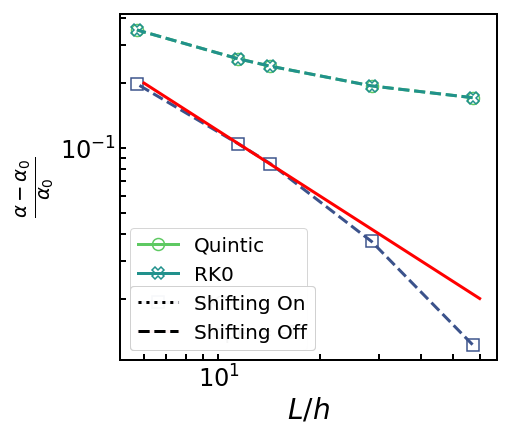

In [30]:
fig, ax = plt.subplots(1,1,figsize=(7,6))

for i in df_conduction_error["kernel_type"].unique():
    subdf = df_conduction_error[df_conduction_error.kernel_type==i]
    subdf = subdf.sort_values(by=["sf"])
    label = i
    ax.loglog(L_x/(subdf["sf"]*hd),subdf["error__alpha"],
                color=color_key[i],
                marker=marker_key[i],
                linestyle="--",
                markerfacecolor="None",
                label=label)

#Add line of slope = 2 for reference
slope = -1
x_ref = [6,60]
y_ref = [2e-1,2e-2]
ax.loglog(x_ref,y_ref, 
            color="red",
            linestyle="solid",
            label="Slope = " + str(slope))


y_label = r"$\frac{\alpha-\alpha_0}{\alpha_0}$"
x_label = r"$L/h$"
filepath = "figures/conduction_convergence.svg"
format_plot(ax,y_label,x_label,filepath)